In [1]:
from langchain_openai import OpenAI
from langchain_community.utilities import ArxivAPIWrapper
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
import os
# Step 3: Initialize LangChain and arXiv Wrapper
os.environ["OPENAI_API_KEY"] = "your key"


from langchain_community.vectorstores import Chroma
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter


In [4]:
embeddings = OpenAIEmbeddings(openai_api_key='your key')
openai_llm = OpenAI(temperature=0)

In [5]:

pdf_folder_path = "/home/abdul/project_onotlogy_rag/pythonProject1/documnets"
documents = []
for file in os.listdir(pdf_folder_path):
    if file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_folder_path, file)
        print(f"Processing {pdf_path}")
        loader = PyPDFLoader(pdf_path)
        documents.extend(loader.load())
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=10)
chunked_documents = text_splitter.split_documents(documents)
vectorstore = Chroma(embedding_function=embeddings,
                 persist_directory="Vectorstore/chromadb",
                 collection_name="full_documents")
vectorstore.add_documents(chunked_documents)
vectorstore.persist()

Processing /home/abdul/project_onotlogy_rag/pythonProject1/documnets/2403.09007v1.pdf
Processing /home/abdul/project_onotlogy_rag/pythonProject1/documnets/2402.18173v2.pdf
Processing /home/abdul/project_onotlogy_rag/pythonProject1/documnets/2309.14435v2.pdf
Processing /home/abdul/project_onotlogy_rag/pythonProject1/documnets/1709.04058v2.pdf
Processing /home/abdul/project_onotlogy_rag/pythonProject1/documnets/2212.02157v1.pdf
Processing /home/abdul/project_onotlogy_rag/pythonProject1/documnets/1905.01592v1.pdf
Processing /home/abdul/project_onotlogy_rag/pythonProject1/documnets/2311.03750v1.pdf


/home/abdul/miniconda3/envs/onot_rag/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [6]:
import pandas as pd

In [7]:
from langchain.chains import RetrievalQA
#
qa = RetrievalQA.from_chain_type(llm=openai_llm,
                                 chain_type="stuff",
                                 retriever=vectorstore.as_retriever(search_kwargs={"k":5}),
                                 return_source_documents=True)

In [8]:
answers = []
contexts = []

questions_df = pd.read_csv("/home/abdul/project_onotlogy_rag/pythonProject1/questions_with_answers.csv")

# Process each question and store the result

for question in questions_df["Questions"]:
  response = qa.invoke({"query" : question})
  answers.append(response["result"])
  contexts.append([context.page_content for context in response['source_documents']])

In [9]:
test_questions = questions_df["Questions"].values.tolist()
test_groundtruths = questions_df["Answers"].values.tolist()

In [11]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [14]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]
#
naive_results = evaluate(response_dataset, metrics,raise_exceptions=False)
naive_results

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

No statements were generated from the answer.
Runner in Executor raised an exception
Traceback (most recent call last):
  File "/home/abdul/miniconda3/envs/onot_rag/lib/python3.10/site-packages/ragas/executor.py", line 78, in _aresults
    r = await future
  File "/home/abdul/miniconda3/envs/onot_rag/lib/python3.10/asyncio/tasks.py", line 571, in _wait_for_one
    return f.result()  # May raise f.exception().
  File "/home/abdul/miniconda3/envs/onot_rag/lib/python3.10/site-packages/ragas/executor.py", line 37, in sema_coro
    return await coro
  File "/home/abdul/miniconda3/envs/onot_rag/lib/python3.10/site-packages/ragas/executor.py", line 111, in wrapped_callable_async
    return counter, await callable(*args, **kwargs)
  File "/home/abdul/miniconda3/envs/onot_rag/lib/python3.10/site-packages/ragas/metrics/base.py", line 125, in ascore
    raise e
  File "/home/abdul/miniconda3/envs/onot_rag/lib/python3.10/site-packages/ragas/metrics/base.py", line 121, in ascore
    score = await s

{'faithfulness': 0.6064, 'answer_relevancy': 0.7066, 'context_recall': 0.4128, 'context_precision': 0.7228, 'answer_correctness': 0.4391}

In [ ]:
{'faithfulness': 0.6621, 'answer_relevancy': 0.5432, 'context_recall': 0.5021, 'context_precision': 0.7066, 'answer_correctness': 0.5316}
{'faithfulness': 0.6064, 'answer_relevancy': 0.7066, 'context_recall': 0.4128, 'context_precision': 0.7228, 'answer_correctness': 0.4391}
{'faithfulness': 0.7907, 'answer_relevancy': 0.6454, 'context_recall': 0.6565, 'context_precision': 0.7344, 'answer_correctness': 0.5718}

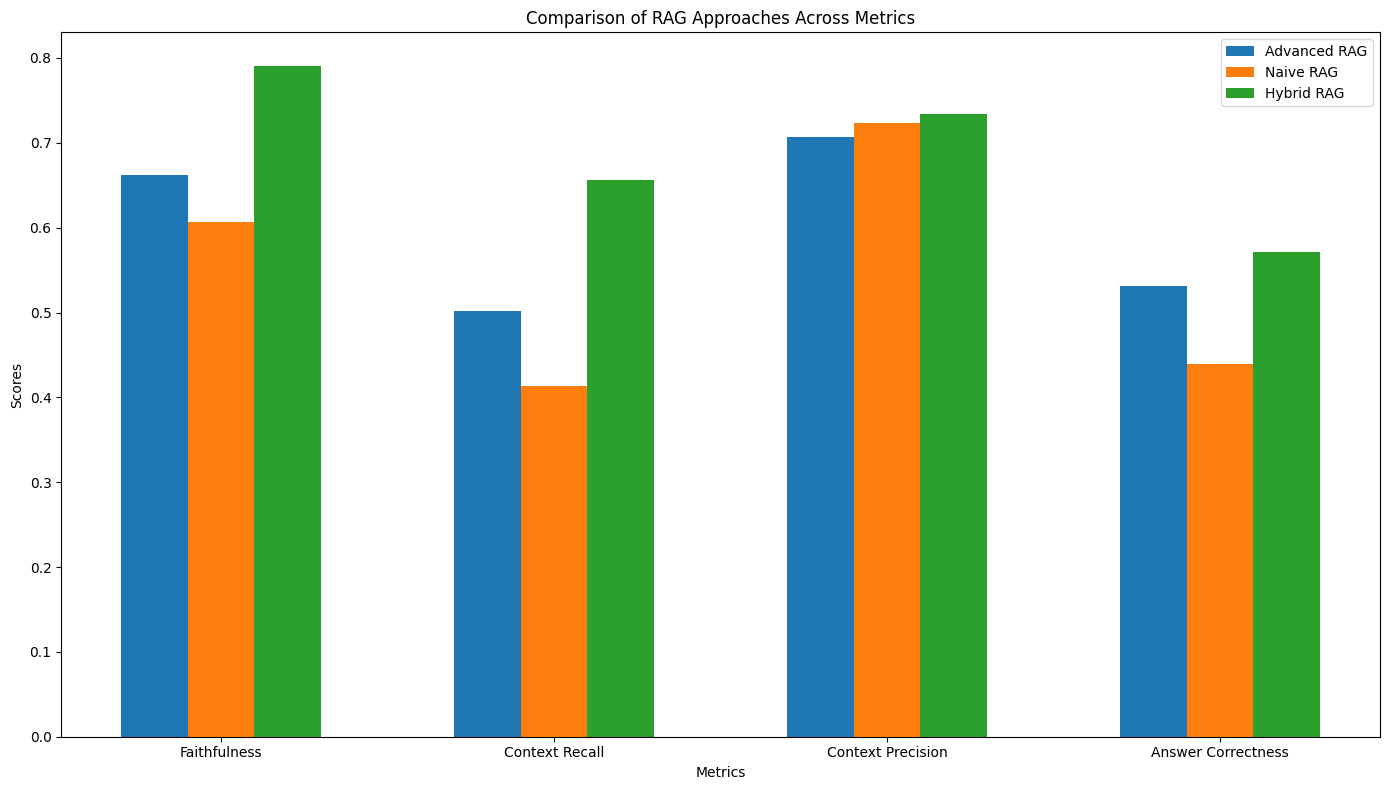

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the updated data
metrics = ['Faithfulness', 'Context Recall', 'Context Precision', 'Answer Correctness']
advanced_rag = [0.6621, 0.5021, 0.7066, 0.5316]
naive_rag = [0.6064, 0.4128, 0.7228, 0.4391]
hybrid_rag = [0.7907, 0.6565, 0.7344, 0.5718]

# Create an updated DataFrame
updated_data = {
    'Metric': metrics,
    'Advanced RAG': advanced_rag,
    'Naive RAG': naive_rag,
    'Hybrid RAG': hybrid_rag
}

updated_df = pd.DataFrame(updated_data)

# Plotting updated graphs
fig, ax = plt.subplots(figsize=(14, 8))

# Bar plot for metrics comparison
x = np.arange(len(metrics))
width = 0.2

ax.bar(x - width, advanced_rag, width, label='Advanced RAG')
ax.bar(x, naive_rag, width, label='Naive RAG')
ax.bar(x + width, hybrid_rag, width, label='Hybrid RAG')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of RAG Approaches Across Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Save the figure
file_path = "rag_comparison_bar_graph.png"
plt.tight_layout()
plt.savefig(file_path)
plt.show()

